In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime
from tqdm import tqdm

import warnings
import os
import sys
import time
import requests
import glob

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def RemoveOutliner(data, feature):
    '''Use statistical method to remove some statistical outliner'''
    data = data[data[feature]>0]      #trip, time, cannot be zero
    upper_bound = data[feature].median() + (data[feature].quantile(0.75)-data[feature].quantile(0.25))*1.5
    lower_bound = data[feature].median() - (data[feature].quantile(0.75)-data[feature].quantile(0.25))*1.5
    data = data[data[feature]<upper_bound]
    data = data[data[feature]>lower_bound]
    return data

In [3]:
def DataCleansing(data):
    data = RemoveOutliner(data, 'trip_duration')
    data = RemoveOutliner(data, 'trip_distance')
    data = RemoveOutliner(data, 'speed')
    return data

In [4]:
def getFile():
    path = "./data/"
    allFiles = glob.glob(path + "/*.csv")
    list_ = []
    for file_ in allFiles:
        df = pd.read_csv(file_)
        list_.append(df)
    df = pd.concat(list_, axis = 0)
    return df

In [5]:
def AddFeatures(data):
    #convert to datetime
    data.tpep_pickup_datetime = pd.to_datetime(data.tpep_pickup_datetime, format='%Y%m%d %H:%M:%S')
    data.tpep_dropoff_datetime = pd.to_datetime(data.tpep_dropoff_datetime, format='%Y%m%d %H:%M:%S')
    #add new feature [trip_duration] and [speed]
    data['trip_duration'] = (data["tpep_dropoff_datetime"] - data["tpep_pickup_datetime"]).dt.total_seconds().astype(int)
    data['speed'] = round((data['trip_distance']/data['trip_duration']*60*60), 2)
    data = data[data["tpep_pickup_datetime"] >= pd.Timestamp(2018, 1, 1)]
    data = data[data["tpep_pickup_datetime"] <= pd.Timestamp(2018, 6, 30)]
    return data

In [6]:
def SelectFeatures(data):
    return data[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'trip_duration', 'speed', 'PULocationID', 'DOLocationID', 'total_amount']]

In [7]:
def DateTime_Binning(data):
    data["pickup_date"] = data.tpep_pickup_datetime.dt.date
    data["pickup_hour"] = data.tpep_pickup_datetime.dt.hour
    data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], inplace=True, axis=1)
    return data

In [8]:
def getData():
    df = getFile()
    df = AddFeatures(df)
    df = SelectFeatures(df)
    df = DataCleansing(df)
    df = DateTime_Binning(df)
    df = df[['pickup_date', 'pickup_hour', 'PULocationID', 'DOLocationID', 'trip_distance', 'trip_duration', 'speed', 'total_amount']]
    df.sort_values(by=['pickup_date', 'pickup_hour', 'PULocationID'], inplace = True)
    df = df.reset_index(drop = True)
    return df

In [9]:
taxidata = getData()

In [10]:
taxidata.head()

,pickup_date,pickup_hour,PULocationID,DOLocationID,trip_distance,trip_duration,speed,total_amount
0,2018-01-01,0,4,232,0.7,283,8.90,6.30
1,2018-01-01,0,4,148,0.8,514,5.60,9.55
2,2018-01-01,0,4,224,1.1,343,11.55,7.30
3,2018-01-01,0,4,232,0.9,462,7.01,7.80
4,2018-01-01,0,4,68,2.9,1217,8.58,15.80


In [11]:
taxidata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39610214 entries, 0 to 39610213
Data columns (total 8 columns):
pickup_date      object
pickup_hour      int64
PULocationID     int64
DOLocationID     int64
trip_distance    float64
trip_duration    int64
speed            float64
total_amount     float64
dtypes: float64(3), int64(4), object(1)
memory usage: 2.4+ GB


In [ ]:
#save taxi data for later use
taxidata.to_csv('taxidata2018.csv')

In [13]:
def getDemands(data):
    hash_header = []
    dict_counter = {}
    for location in range(1, 266):
        for month in [1, 3, 5]: 
            for day in range(1, 32):
                for hour in range(0, 24):
                    name = str(location) + '#' + str(month) + '#' + str(day) + '#' + str(hour)
                    hash_header.append(name)
                    dict_counter[name] = 0
        for month in [2]:
            for day in range(1, 29):
                for hour in range(0, 24):
                    name = str(location) + '#' + str(month) + '#' + str(day) + '#' + str(hour)
                    hash_header.append(name)
                    dict_counter[name] = 0
        for month in [4, 6]:
            for day in range(1, 31):
                for hour in range(0, 24):
                    name = str(location) + '#' + str(month) + '#' + str(day) + '#' + str(hour)
                    hash_header.append(name)
                    dict_counter[name] = 0

    df_rows = data.iterrows()
    for index, row in data.iterrows():
        record = str(row['PULocationID']) +'#' + str(row['pickup_month']) + '#' + str(row['pickup_dayofmonth']) + '#' + str(row['pickup_hour'])
        dict_counter[record] += 1

    df_count = pd.DataFrame(list(dict_counter.items()), columns=['k','count'])
    df_count_split = df_count['k'].str.split("#" ,expand = True)
    df_count_split.columns = ['PULocationID', 'pickup_month', 'pickup_dayofmonth', 'pickup_hour']
    freqTable = pd.concat([df_count_split, df_count['count']], axis = 1)

    return freqTable

In [16]:
taxidata.pickup_date = pd.to_datetime(taxidata.pickup_date, format='%Y%m%d %H:%M:%S')
taxidata["pickup_month"] = taxidata.pickup_date.dt.month
taxidata["pickup_dayofmonth"] = taxidata.pickup_date.dt.day

In [17]:
freqTable = getDemands(taxidata)

In [18]:
freqTable.head()

,PULocationID,pickup_month,pickup_dayofmonth,pickup_hour,count
0,1,1,1,0,0
1,1,1,1,1,0
2,1,1,1,2,0
3,1,1,1,3,1
4,1,1,1,4,0


In [41]:
freqTable.PULocationID = freqTable.PULocationID.astype(int)
freqTable.pickup_month = freqTable.pickup_month.astype(int)
freqTable.pickup_dayofmonth = freqTable.pickup_dayofmonth.astype(int)
freqTable.pickup_hour = freqTable.pickup_hour.astype(int)

In [47]:
dfm = list(freqTable['pickup_month'])
dfd = list(freqTable['pickup_dayofmonth'])
freqTable['Date'] = pd.Timestamp(2018, 1, 1)
for i in range(freqTable.shape[0]):
    freqTable.loc[i, ('Date')] = pd.Timestamp(2018, dfm[i], dfd[i])

demandCount = freqTable[['Date', 'pickup_hour', 'PULocationID', 'count']]

In [50]:
demandCount.head()

,Date,pickup_hour,PULocationID,count
0,2018-01-01,0,1,0
1,2018-01-01,1,1,0
2,2018-01-01,2,1,0
3,2018-01-01,3,1,1
4,2018-01-01,4,1,0


In [19]:
def getZoneDict(data):
    '''Because there are 265 taxi zone in NYC, I only focus on Manahttan and the aiports.  The yellow zone is manhattan '''
    loc_id = list(data.LocationID)
    loc_zone = list(data.Zone)
    ATZ_dict = dict(zip(loc_id, loc_zone))
    ATZ_dict[-1] = np.nan

    selected_neighborhood = data[(data.service_zone == 'Yellow Zone')|(data.service_zone == 'Airports') | (data.service_zone == 'EWR')]
    selectlist = list(selected_neighborhood.LocationID)
    selectzone = list(selected_neighborhood.Zone)
    selected_dict = dict(zip(selectlist, selectzone))
    return ATZ_dict, selected_dict, selectlist

In [20]:
def getCountLabel(data1, data2):
    data2.rename(columns = {'Date': 'pickup_date'}, inplace = True)
    data1.set_index(['pickup_date', 'pickup_hour', 'PULocationID'], inplace=True)
    data2.set_index(['pickup_date', 'pickup_hour', 'PULocationID'], inplace=True)

    CountLabel = data2.join(data1, how = 'outer')
    CountLabel = CountLabel.reset_index(drop = False)
    return CountLabel

In [57]:
loopupTable = pd.read_csv('taxi_zone_lookup.csv')
long_dict, short_dict, sel_list = getZoneDict(loopupTable)

In [58]:
CountTable = getCountLabel(taxiTable, demandCount)
CountTable = CountTable[CountTable['PULocationID'].isin(sel_list)]
CountTable['PULoc_name'] = pd.Series(list(map(lambda x:short_dict[x],list(CountTable['PULocationID'].values))))
CountTable.DOLocationID = CountTable['DOLocationID'].fillna(-1)   #if the destination is not within yellow zone, the transaction will be ignored
CountTable['DOLoc_name'] = pd.Series(list(map(lambda x:long_dict[x],list(CountTable['DOLocationID'].values))))

In [60]:
CountTable.pickup_date = pd.to_datetime(CountTable.pickup_date, format='%Y%m%d %H:%M:%S')
CountTable["pickup_dayofweek"] = CountTable.pickup_date.dt.dayofweek
CountTable = CountTable[['pickup_date', 'pickup_hour', 'pickup_dayofweek', 'PULocationID', 'PULoc_name', 'DOLocationID', 'DOLoc_name', 'trip_distance', 'trip_duration', 'speed', 'total_amount', 'count']]

In [61]:
CountTable.head()

,pickup_date,pickup_hour,pickup_dayofweek,PULocationID,PULoc_name,DOLocationID,DOLoc_name,trip_distance,trip_duration,speed,total_amount,count
0,2018-01-01,0,0,1,Newark Airport,-1.0,NaN,NaN,NaN,NaN,NaN,0
3,2018-01-01,0,0,4,Alphabet City,232.0,Stuy Town/Peter Cooper Village,0.7,283.0,8.90,6.30,59
4,2018-01-01,0,0,4,Alphabet City,148.0,Two Bridges/Seward Park,0.8,514.0,5.60,9.55,59
5,2018-01-01,0,0,4,Alphabet City,224.0,East Chelsea,1.1,343.0,11.55,7.30,59
6,2018-01-01,0,0,4,Alphabet City,232.0,Greenwich Village South,0.9,462.0,7.01,7.80,59


In [62]:
CountTable = CountTable.dropna(axis = 0, inplace = False)
CountTable = CountTable.reset_index(drop = True)
CountTable.head()

,pickup_date,pickup_hour,pickup_dayofweek,PULocationID,PULoc_name,DOLocationID,DOLoc_name,trip_distance,trip_duration,speed,total_amount,count
0,2018-01-01,0,0,4,Alphabet City,232.0,Stuy Town/Peter Cooper Village,0.7,283.0,8.90,6.30,59
1,2018-01-01,0,0,4,Alphabet City,148.0,Two Bridges/Seward Park,0.8,514.0,5.60,9.55,59
2,2018-01-01,0,0,4,Alphabet City,224.0,East Chelsea,1.1,343.0,11.55,7.30,59
3,2018-01-01,0,0,4,Alphabet City,232.0,Greenwich Village South,0.9,462.0,7.01,7.80,59
4,2018-01-01,0,0,4,Alphabet City,68.0,Kips Bay,2.9,1217.0,8.58,15.80,59


In [64]:
WeatherFeature = pd.read_csv('WeatherFeature.csv',  index_col = 0)
WeatherFeature.head()

,pickup_date,pickup_hour,Condition,Precip,Precip_Accum
0,2018-01-01,0,1.0,0.0,0.0
1,2018-01-01,1,1.0,0.0,0.0
2,2018-01-01,2,1.0,0.0,0.0
3,2018-01-01,3,1.0,0.0,0.0
4,2018-01-01,4,1.0,0.0,0.0


In [4]:
_modeldata = pd.read_csv('taxidataforML.csv', index_col = 0)

In [77]:
_modeldata.head()

,pickup_date,pickup_hour,Condition,Precip,Precip_Accum,pickup_dayofweek,PULocationID,PULoc_name,DOLocationID,DOLoc_name,trip_distance,trip_duration,speed,total_amount,count
0,2018-01-01,0,1.0,0.0,0.0,0.0,4.0,Alphabet City,232.0,Stuy Town/Peter Cooper Village,0.7,283.0,8.90,6.30,59.0
1,2018-01-01,0,1.0,0.0,0.0,0.0,4.0,Alphabet City,148.0,Two Bridges/Seward Park,0.8,514.0,5.60,9.55,59.0
2,2018-01-01,0,1.0,0.0,0.0,0.0,4.0,Alphabet City,224.0,East Chelsea,1.1,343.0,11.55,7.30,59.0
3,2018-01-01,0,1.0,0.0,0.0,0.0,4.0,Alphabet City,232.0,Greenwich Village South,0.9,462.0,7.01,7.80,59.0
4,2018-01-01,0,1.0,0.0,0.0,0.0,4.0,Alphabet City,68.0,Kips Bay,2.9,1217.0,8.58,15.80,59.0


In [78]:
_modeldata.shape

(36451106, 15)

In [5]:
_modeldata.pickup_date = pd.to_datetime(_modeldata.pickup_date, format='%Y%m%d %H:%M:%S')

In [6]:
TestSet = _modeldata[_modeldata.pickup_date > pd.Timestamp(2018,6,7)]
TestSet = TestSet[TestSet.pickup_date < pd.Timestamp(2018,6,15)]
TestSet.sort_values(by=['pickup_date', 'pickup_hour', 'PULocationID'], inplace = True)
TestSet = TestSet.dropna()
TestSet.head()

,pickup_date,pickup_hour,Condition,Precip,Precip_Accum,pickup_dayofweek,PULocationID,PULoc_name,DOLocationID,DOLoc_name,trip_distance,trip_duration,speed,total_amount,count
32612214,2018-06-08,0,1.0,0.0,0.0,4.0,4.0,Yorkville East,231.0,Lenox Hill West,2.26,952.0,8.55,15.10,24.0
32612215,2018-06-08,0,1.0,0.0,0.0,4.0,4.0,Yorkville East,87.0,Midtown Center,2.90,651.0,16.04,15.95,24.0
32612216,2018-06-08,0,1.0,0.0,0.0,4.0,4.0,Yorkville East,79.0,Midtown North,0.61,250.0,8.78,6.67,24.0
32612217,2018-06-08,0,1.0,0.0,0.0,4.0,4.0,Yorkville East,233.0,Lenox Hill East,1.90,655.0,10.44,12.43,24.0
32612218,2018-06-08,0,1.0,0.0,0.0,4.0,4.0,Yorkville East,148.0,Upper East Side North,0.80,278.0,10.36,8.16,24.0


In [87]:
TestSet.shape

(1383510, 15)

In [7]:
Train_Val_Set = _modeldata[_modeldata.pickup_date < pd.Timestamp(2018,6,8)]
Train_Val_Set.sort_values(by=['pickup_date', 'pickup_hour', 'PULocationID'], inplace = True)

/Users/brian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [8]:
Train_Set = _modeldata[_modeldata.pickup_date < pd.Timestamp(2018,6,1)]
Train_Set.sort_values(by=['pickup_date', 'pickup_hour', 'PULocationID'], inplace = True)

/Users/brian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
Val_Set = Train_Val_Set[Train_Val_Set.pickup_date >= pd.Timestamp(2018,6,1)]
Val_Set.sort_values(by=['pickup_date', 'pickup_hour', 'PULocationID'], inplace = True)

/Users/brian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
TestSet.shape

(1383510, 15)

In [11]:
Train_Val_Set.shape

(33025589, 15)

In [12]:
Train_Set.shape

(31574488, 15)

In [13]:
Val_Set.shape

(1451101, 15)

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

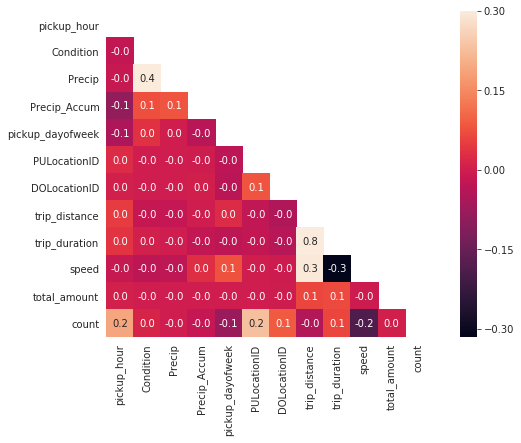

In [98]:
plt.figure(figsize=(10,6))
corr = Train_Val_Set.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot = True, fmt=".1f")
plt.show()

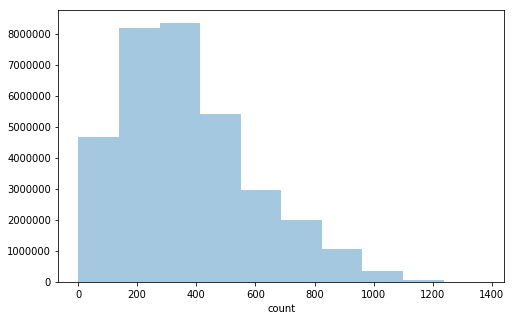

In [100]:
plt.figure(figsize=(8,5))
sns.distplot(Train_Val_Set['count'], bins = 10, kde=False)

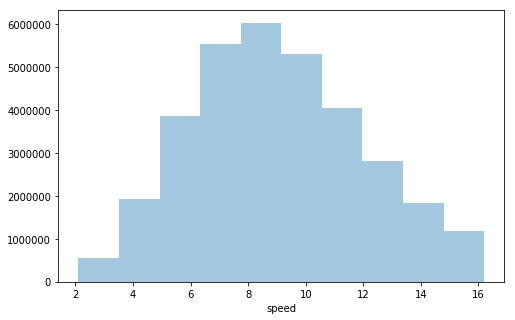

In [102]:
plt.figure(figsize=(8,5))
sns.distplot(Train_Val_Set['speed'], bins = 10, kde=False)

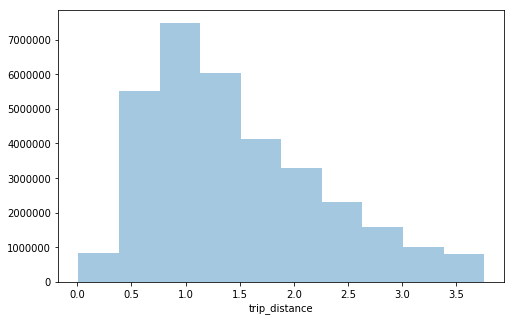

In [103]:
plt.figure(figsize=(8,5))
sns.distplot(Train_Val_Set['trip_distance'], kde=False, bins = 10)

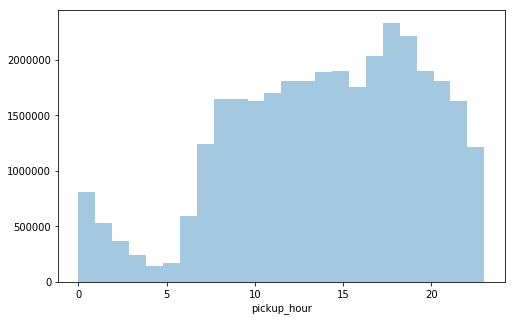

In [104]:
plt.figure(figsize=(8,5))
sns.distplot(Train_Val_Set['pickup_hour'], kde=False, bins = 24)

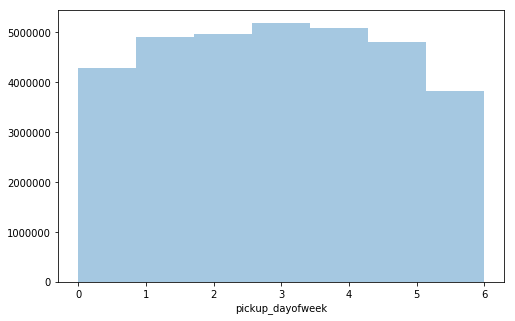

In [105]:
plt.figure(figsize=(8,5))
sns.distplot(Train_Val_Set['pickup_dayofweek'], kde=False, bins = 7)

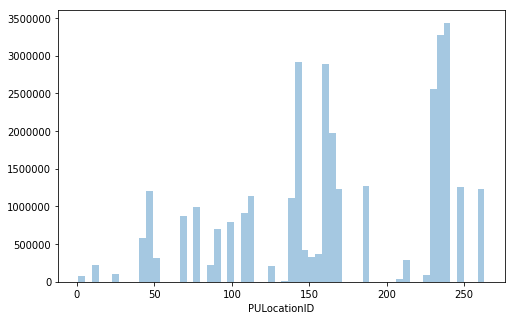

In [106]:
plt.figure(figsize=(8,5))
sns.distplot(Train_Val_Set['PULocationID'], bins = 60, kde=False)

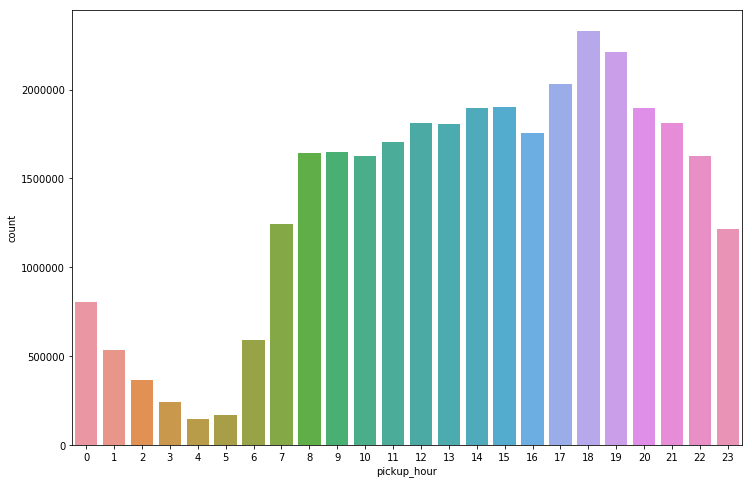

In [107]:
plt.figure(figsize=(12,8))
sns.countplot(x="pickup_hour", data=Train_Val_Set)
plt.show()

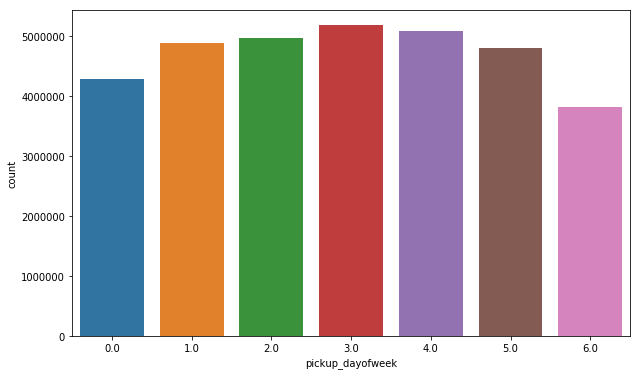

In [108]:
plt.figure(figsize=(10,6))
sns.countplot(x="pickup_dayofweek", data=Train_Val_Set)
plt.show()

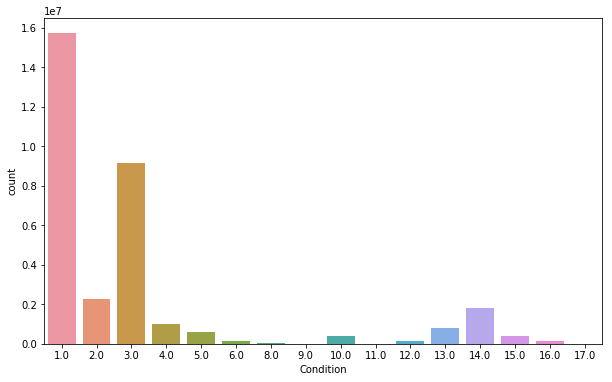

In [109]:
plt.figure(figsize=(10,6))
sns.countplot(x="Condition", data=Train_Val_Set)
plt.show()

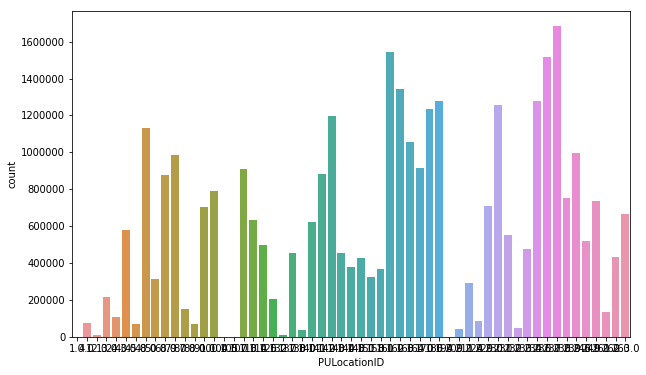

In [110]:
plt.figure(figsize=(10,6))
sns.countplot(x="PULocationID", data=Train_Val_Set)
plt.show()

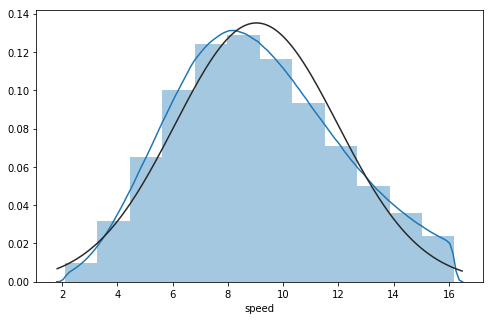

<Figure size 432x288 with 0 Axes>

In [111]:
#histogram and normal probability plot
plt.figure(figsize=(8,5))
from scipy.stats import norm
sns.distplot(Train_Val_Set['speed'], bins = 12, fit=norm);
fig = plt.figure()

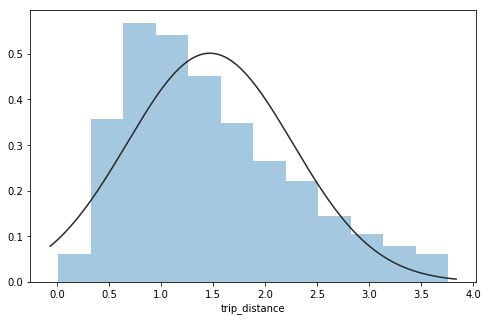

In [112]:
plt.figure(figsize=(8,5))
sns.distplot(Train_Val_Set['trip_distance'], kde = False, bins = 12, fit=norm);